## **Using a Convolutional Neural Network to Identify Simulated Nanoparticle Rotations | Regression Model**

In this notebook, a convolutional neural network will be constructed and trained on images of simulated nanoparticles. The aim of the neural network is to correctly identify the rotations of these nanoparticles. TensorFlow2 and Keras will be used to create a regression model.

All of my work can be found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

# Importing the relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import csv
from scipy.spatial.transform import Rotation as R

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Creating the dataset.

The images are loaded in from Google Drive.

In [2]:
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path, force_remount=True)

cwd = os.path.join(drive_path, "MyDrive", "Nanoparticles")
folder_name = "Mixed Dataset W 12-13 RX 0-45 RY 0-45"
direc = os.path.join(cwd, folder_name)

Mounted at /content/drive


The following function creates a Tensorflow dataset from a specified folder. It resizes all images to the specified size and and loads them in as a grayscale image.

In [3]:
def create_dataset(directory, img_size=[64, 64], batch_size=32):
  """
  Creates TensorFlow dataset from specified path. The image size after resizing
  is specified as is the batch size.

  Inputs:
    directory: String, folder containing all subfolders of images
    img_size: List, size to resize images
    batch_size: Integer, batch size to use for dataset

  Outputs:
    dataset: TensorFlow dataset, image dataset from files
  """
  print("Assigning images to '%s' dataset..." % (directory.split("/")[-1]))
  dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale'
  )
  
  return dataset

The required folder paths are specified, and the training and validation datasets are assigned. 80% of the images in total are used for training, and 20% for validation.

In [4]:
batch_size = 16
img_size = [64, 64] # Image dimensions

dr_train = 15
training_path = os.path.join(direc, "Train DR%s" % dr_train)
validation_path = os.path.join(direc, "Valid DR%s" % dr_train)

In [5]:
train_ds = create_dataset(training_path, img_size=img_size, batch_size=batch_size)
valid_ds = create_dataset(validation_path, img_size=img_size, batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names) # Number of categories

Assigning images to 'Train DR15' dataset...
Found 384 files belonging to 48 classes.
Assigning images to 'Valid DR15' dataset...
Found 96 files belonging to 48 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

The pixel values of each image are mapped to a float between 0 and 1. Random zooms are then applied for augmentation to increase the accuracy of the model as well as random changes to contrast.

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.Rescaling(1./255.),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15)
  ]
)

# Creating the model.

The following function shows the layers of the convolutional neural network.

In [8]:
def get_model(n_outputs):
  """
  Creates a TensorFlow neural network.

  Inputs:
    n_outputs: Integer, number of output nodes of the model

  Outputs:
    model: TensorFlow sequential, model to train
  """
  model = Sequential([
    layers.InputLayer(input_shape=(*img_size, 1)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(*img_size, 1), name='Convolution_16_3x3'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_1'),
    layers.Conv2D(32, 3, padding='same', activation='relu', name='Convolution_32_3x3'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_2'),
    layers.Conv2D(64, 3, padding='same', activation='relu', name='Convolution_64_3x3'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_3'),
    layers.Dropout(0.2, name='Dropout_20'),
    layers.Flatten(name='Flatten'),
    layers.Dense(img_size[0], activation='relu', kernel_initializer='he_uniform', name='Dense_%s' % img_size[0]),
    layers.Dense(n_outputs, kernel_initializer='he_uniform', name='Dense_%s' % n_outputs)
  ])

  return model

The model is created and compiled using sparse categorical crossentropy for the loss.

In [9]:
model = get_model(num_classes)
model._name = "Nanoparticle_Classification"

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "Nanoparticle_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 1)         0         
                                                                 
 Convolution_16_3x3 (Conv2D)  (None, 64, 64, 16)       160       
                                                                 
 Max_Pooling_2x2_Stride_2_1   (None, 32, 32, 16)       0         
 (MaxPooling2D)                                                  
                                                                 
 Convolution_32_3x3 (Conv2D)  (None, 32, 32, 32)       4640      
                                                                 
 Max_Pooling_2x2_Stride_2_2   (None, 16, 16, 32)       0         
 (MaxPooling2D)                                                  
                                                                 
 Convolution_64_3x3 (Conv2D)  (None, 16

# Training the model.

The model is trained for 50 epochs.

In [10]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/50
24/24 [==============================] - 52s 515ms/step - loss: 3.8628 - accuracy: 0.0260 - val_loss: 3.8035 - val_accuracy: 0.0729
Epoch 2/50
24/24 [==============================] - 2s 77ms/step - loss: 3.7184 - accuracy: 0.0391 - val_loss: 3.5153 - val_accuracy: 0.0625
Epoch 3/50
24/24 [==============================] - 2s 76ms/step - loss: 3.4880 - accuracy: 0.0521 - val_loss: 3.2704 - val_accuracy: 0.0625
Epoch 4/50
24/24 [==============================] - 2s 78ms/step - loss: 3.1745 - accuracy: 0.0885 - val_loss: 2.8121 - val_accuracy: 0.1771
Epoch 5/50
24/24 [==============================] - 2s 77ms/step - loss: 2.8456 - accuracy: 0.1250 - val_loss: 2.4685 - val_accuracy: 0.2292
Epoch 6/50
24/24 [==============================] - 2s 77ms/step - loss: 2.4661 - accuracy: 0.1979 - val_loss: 2.1904 - val_accuracy: 0.2396
Epoch 7/50
24/24 [==============================] - 2s 76ms/step - loss: 2.1700 - accuracy: 0.2760 - val_loss: 1.8591 - val_accuracy: 0.3438
Epoch 8/50


Visualising the training results.

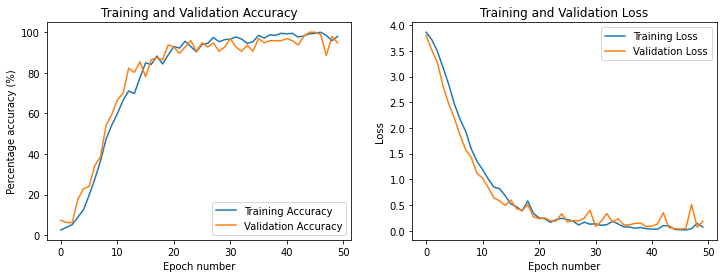

In [11]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc * 100, label='Training Accuracy')
plt.plot(epochs_range, val_acc * 100, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch number")
plt.ylabel("Percentage accuracy (%)")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

# Using the test dataset to assess the model's prediction accuracy.

The following class handles predictions for each group in the test dataset, each group being a subfolder in the test dataset folder. Each group corresponds to a different orientation of the nanoparticle in the image. The class loads in the images from the subfolder and creates a TensorFlow dataset.

The rotations are applied to the nanoparticles using 3x3 rotation matrices. The Gram–Schmidt process can then be used to represent this 3x3 matrix in 6D. The class can convert this 6D representation back into a matrix from which the Euler angles can be calculated.

The absolute difference between the predicted and true rotation for each image is then calculated, and this can be plotted as well as the predictions themselves.

In [12]:
myl = [1, 2]
mya = np.array(myl)
myl2 = mya.tolist()
print(myl2)

[1, 2]


In [13]:
class prediction_handler:
  """
  This class is used to store data about predicted images from each rotation.
  The folder path is specified and the shape and its rotation are saved. Each
  image belonging to that shape and rotation is then used to test the model and
  the average absolute difference between the true and predicted rotations are
  is calculated.
  """
  def __init__(self, folder_path):
    """
    Initialise the class.

    Inputs:
      folder_path: String, subfolder in training folder with shape and rotation
    """
    self.folder_path = folder_path
    label = self.folder_path.split("/")[-1]
    self.actual_shape = label.split("_")[0]
    self.actual_rotation = self.calculate_euler(json.loads(label.split("_")[-1]))
    self.correct_shape_predictions = 0
    self.load_img_paths()
    self.run()

  def calculate_euler(self, label):
    """
    Calculates Euler angles from 6D representation of rotation.

    Inputs:
      label: List, 6 floats corresponding to numbers in rotation matrix

    Outputs:
      rotation_euler: NumPy array, 1x3 array of Euler angles rounded to 1dp
    """
    rotation = np.array(label).reshape((2, 3)).T
    
    v1 = rotation[:, 0]
    v2 = rotation[:, 1]
    e1 = v1 / np.linalg.norm(v1)
    u2 = v2 - (np.dot(np.dot(e1, v2), e1))
    e2 = u2 / np.linalg.norm(u2)
    e3 = np.cross(e1, e2)

    rotation_so3 = np.vstack((e1, e2, e3)).T

    rotation_euler = R.from_matrix(rotation_so3).as_euler("xyz", degrees=True)

    return np.round(rotation_euler, 1)

  def load_img_paths(self):
    """
    Appends the path to each image to a list.
    """
    img_paths = []

    for img_path in os.listdir(self.folder_path):
      if img_path not in img_paths:
        img_paths.append(os.path.join(self.folder_path, img_path))
    
    self.img_paths = img_paths

  def predict_image(self, img_path):
    """
    Predicts a specified image using neural network.

    Inputs:
      img_path: String, path to image being used
    """
    img = tf.keras.utils.load_img(img_path, target_size=img_size, color_mode="grayscale")
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    prediction = class_names[np.argmax(score)].split("_")
    
    predicted_shape = prediction[0]
    if predicted_shape == self.actual_shape:
      self.correct_shape_predictions += 1

    predicted_angle = prediction[-1]
    predicted_rotation = self.calculate_euler(json.loads(predicted_angle))
    return predicted_rotation

  def run(self):
    """
    Predicts each image belonging to this class and calculates the average
    absolute difference between true and predicted rotations.
    """
    self.predictions = []

    for img_path in self.img_paths:
      self.predictions.append(self.predict_image(img_path))

    self.predictions = np.asarray(self.predictions)
    self.avg_pred = np.mean(self.predictions, axis=0)
    
    self.dif = np.abs(self.predictions - self.actual_rotation)
    self.avg_dif = np.mean(self.dif, axis=0)
    self.total_shapes = len(self.predictions)

  def plot_predictions(self):
    """
    Plots the neural network's predictions.
    """
    plt.figure(figsize=(12, 7))
    x = np.arange(self.total_shapes)

    plt.scatter(x, self.predictions[:,0], c='b')#, label='Predicted angle rx')
    plt.hlines(self.avg_pred[0], x[0], x[-1], 'b', label='Average predicted angle rx = %s°' % np.round(self.avg_pred[0], 2))
    plt.hlines(self.actual_rotation[0], x[0], x[-1], 'b', linestyles='dashed', label='Expected angle rx = %s°' % self.actual_rotation[0])

    plt.scatter(x, self.predictions[:,1], c='r')#, label='Predicted angle ry')
    plt.hlines(self.avg_pred[1], x[0], x[-1], 'r', label='Average predicted angle ry = %s°' % np.round(self.avg_pred[1], 2))
    plt.hlines(self.actual_rotation[1], x[0], x[-1], 'r', linestyles='dashed', label='Expected angle ry = %s°' % self.actual_rotation[1])

    plt.scatter(x, self.predictions[:,2], c='g')#, label='Predicted angle rz')
    plt.hlines(self.avg_pred[2], x[0], x[-1], 'g', label='Average predicted angle rz = %s°' % np.round(self.avg_pred[2], 2))
    plt.hlines(self.actual_rotation[2], x[0], x[-1], 'g', linestyles='dashed', label='Expected angle rz = %s°' % self.actual_rotation[2])

    plt.ylabel("Predicted angle (°)")
    plt.xlim([x[0], x[-1]])
    plt.ylim([-45, 45])
    plt.legend(loc='best')
    plt.title("Model Predictions | Euler Angles RX%s RY%s RZ%s" % (self.actual_rotation[0], self.actual_rotation[1], self.actual_rotation[2]))
    plt.show()

  def plot_difs(self):
    """
    Plots the difference between the neural network's predictions and the true rotation.
    """
    plt.figure(figsize=(12, 7))
    x = np.arange(self.total_shapes)
    plt.scatter(x, self.dif[:,0], c='b', label='Absolute difference in rx')
    plt.hlines(self.avg_dif[0], x[0], x[-1], 'b', label='Average difference in rx = %s°' % self.avg_dif[0])
    plt.scatter(x, self.dif[:,1], c='r', label='Absolute difference in ry')
    plt.hlines(self.avg_dif[1], x[0], x[-1], 'r', label='Average difference in ry = %s°' % self.avg_dif[1])
    plt.scatter(x, self.dif[:,2], c='g', label='Absolute difference in rz')
    plt.hlines(self.avg_dif[2], x[0], x[-1], 'g', label='Average difference in rz = %s°' % self.avg_dif[2])
    plt.ylabel("Difference in angle (°)")
    plt.xlim([x[0], x[-1]])
    plt.ylim([0, 45])
    plt.legend(loc='best')
    plt.title("Model Predictions | Euler Angles RX%s RY%s RZ%s" % (self.actual_rotation[0], self.actual_rotation[1], self.actual_rotation[2]))
    plt.show()

# Loading in the images.

The images in each group are used to test the model. The predictions are then sorted to be displayed in a graph.

The average predicted angles and absolute differences between the true and predicted angles are plotted versus true rotation around the x-axis and y-axis. The different lines in both graphs represent different angles of rotation about the other axis to the one shown in each graph, with black to red representing increasing angle.

The data is saved to a .csv file to be analysed in the notebook *AnalyseModelPredictions.ipynb*. If the file does not exist already then one is created and headers are added in the first row. The data to be added is the angle between each orientation in the training and test dataset as well as the average absolute difference between the true and predicted rotations.

In [14]:
class shape_group:
  """
  This class is used to separate the model's predictions by shape. For each
  shape, the average predictions of the model and differences from the true
  rotations are plotted. The graphs are saved and the data is saved to a .csv
  file.
  """
  def __init__(self, shape, testing_path):
    """
    Initialise the class.

    Inputs:
      shape: String, shape of simulated nanoparticle
      testing_path: String, folder containing 
    """
    self.shape = shape
    self.testing_path = testing_path

    self.run()
    self.plot_predictions()
    self.plot_differences()

  def sort_and_reshape_array(self, true_rots, avg_preds, avg_difs, indices):
    """
    Sorts the true rotations and average differences in order of increasing angle.
    The indices determine which axis to use for the order.

    Inputs:
      true_rots: NumPy array, Nx3 array of Euler angles
      avg_preds: NumPy array, Nx3 array of predicted rotations
      avg_difs: NumPy array, Nx3 array of differences between true and predicted rotations
      indices: List, [0,1] to sort using x-axis, [1, 0] for y-axis

    Outputs:
      ordered_rots: NumPy array, Nx3 sorted array of Euler angles
      ordered_avg_pred_rotations: NumPy array, Nx3 sorted array of predicted angles
      ordered_avg_dif_rotations: NumPy array, Nx3 sorted array of differences between true and predicted rotations
    """
    order = np.lexsort((true_rots[:,indices[0]], true_rots[:,indices[1]]))
    ordered_rots = true_rots[order]
    ordered_avg_pred_rotations = avg_preds[order]
    ordered_avg_dif_rotations = avg_difs[order]

    new_shape_dim = int(np.sqrt(ordered_rots.shape[0]))
    new_shape = (new_shape_dim, new_shape_dim, ordered_rots.shape[1])

    ordered_rots = ordered_rots.reshape((new_shape))
    ordered_avg_pred_rotations = ordered_avg_pred_rotations.reshape((new_shape))
    ordered_avg_dif_rotations = ordered_avg_dif_rotations.reshape((new_shape))

    return ordered_rots, ordered_avg_pred_rotations, ordered_avg_dif_rotations

  def run(self):
    """
    Predict each image, sort and plot the results of the model's predictions.
    """
    print("%s:" % self.shape)
    true_rotations = [] # True rotations of each simulated nanoparticle
    prediction_groups = []
    avg_pred_rotations = []
    avg_dif_rotations = [] # Average absolute difference between true and predicted rotations
    correct_shape_predictions = []

    counter = 1
    rotations = [rotation for rotation in os.listdir(self.testing_path) if rotation.startswith(self.shape)]
    total_rotations = len(rotations)

    for rotation in rotations:
      print("\rPredicting rotation %s of %s." % (counter, total_rotations), end='', flush=True)
      rotation_path = os.path.join(self.testing_path, rotation)
      rotation_object = prediction_handler(rotation_path)
      prediction_groups.append(rotation_object)
      true_rotations.append(rotation_object.actual_rotation)
      avg_pred_rotations.append(rotation_object.avg_pred)
      avg_dif_rotations.append(rotation_object.avg_dif)
      correct_shape_predictions.append(rotation_object.correct_shape_predictions / rotation_object.total_shapes)
      counter += 1

    print("\rAll rotations predicted.", end='', flush=True)

    true_rotations = np.asarray(true_rotations)
    prediction_groups = np.asarray(prediction_groups)
    avg_pred_rotations = np.asarray(avg_pred_rotations)
    avg_dif_rotations = np.asarray(avg_dif_rotations)
    self.correct_shapes = np.mean(correct_shape_predictions)

    self.rx_min = np.min(true_rotations[:,0])
    self.rx_max = np.max(true_rotations[:,0])
    self.ry_min = np.min(true_rotations[:,1])
    self.ry_max = np.max(true_rotations[:,1])

    self.ordered_rots_x, self.ordered_avg_pred_x, self.ordered_avg_dif_x = self.sort_and_reshape_array(true_rotations, avg_pred_rotations, avg_dif_rotations, [0, 1])
    self.ordered_rots_y, self.ordered_avg_pred_y, self.ordered_avg_dif_y = self.sort_and_reshape_array(true_rotations, avg_pred_rotations, avg_dif_rotations, [1, 0])
  
  def plot_predictions(self):
    """
    Plot the model's predictions.
    """
    self.fig_pred = plt.figure(figsize=(24, 7))

    plt.subplot(121)

    for index in range(self.ordered_rots_x.shape[0]):
      actual_rotation = self.ordered_rots_x[index][:,0]
      rotation_pred = self.ordered_avg_pred_x[index][:,0]
      plt.plot(actual_rotation, rotation_pred, c=(index / self.ordered_rots_x.shape[0], 0.2, 0.3), label='RY%s RZ%s' % (self.ordered_rots_x[index][0][1], self.ordered_rots_x[index][0][2]))

    plt.xlabel("Actual RX rotation (°)", fontsize=16)
    plt.ylabel("Average predicted angle (°)", fontsize=16)
    plt.xlim([self.rx_min, self.rx_max])
    plt.ylim([0, 45])
    plt.title("Average Predicted RX", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.legend(loc='best', fontsize=14)

    plt.subplot(122)

    for index in range(self.ordered_rots_y.shape[0]):
      actual_rotation = self.ordered_rots_y[index][:,1]
      rotation_pred = self.ordered_avg_pred_y[index][:,1]
      plt.plot(actual_rotation, rotation_pred, c=(index / self.ordered_rots_y.shape[0], 0.2, 0.3), label="RX%s RZ%s" % (self.ordered_rots_y[index][0][0], self.ordered_rots_y[index][0][2]))

    plt.xlabel("Actual RY rotation (°)", fontsize=16)
    plt.xlim([self.ry_min, self.ry_max])
    plt.ylim([0, 45])
    plt.title("Average Predicted RY", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.legend(loc='best', fontsize=14)

    plt.suptitle("%s Predictions For: %s | Training Interval %s° | Testing Interval %s°" % (self.shape, folder_name, dr_train, dr_test), fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

    plt.show()

  def plot_differences(self):
    """
    Plot the average absolute difference between the model's predictions and the
    true rotations.
    """
    drx = []
    dry = []

    self.fig_dif = plt.figure(figsize=(24, 7))

    plt.subplot(121)

    for index in range(self.ordered_rots_x.shape[0]):
      actual_rotation = self.ordered_rots_x[index][:,0]
      rotation_dif = self.ordered_avg_dif_x[index][:,0]
      plt.plot(actual_rotation, rotation_dif, c=(index / self.ordered_rots_x.shape[0], 0.2, 0.3), label="RY%s RZ%s" % (self.ordered_rots_x[index][0][1], self.ordered_rots_x[index][0][2]))
      drx.append(rotation_dif)

    drx = np.asarray(drx)
    self.mean_x = np.mean(drx)
    plt.hlines(self.mean_x, self.rx_min, self.rx_max, color='g', label="Mean difference in RX = %s°" % round(self.mean_x, 2))
    plt.xlabel("Actual RX rotation (°)", fontsize=16)
    plt.ylabel("Average difference in angle (°)", fontsize=16)
    plt.xlim([self.rx_min, self.rx_max])
    plt.ylim([self.rx_min, self.rx_max])
    plt.title("Average Difference in RX", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.legend(loc='best', fontsize=14)

    plt.subplot(122)

    for index in range(self.ordered_rots_y.shape[0]):
      actual_rotation = self.ordered_rots_y[index][:,1]
      rotation_dif = self.ordered_avg_dif_y[index][:,1]
      plt.plot(actual_rotation, rotation_dif, c=(index / self.ordered_rots_y.shape[0], 0.2, 0.3), label="RX%s RZ%s" % (self.ordered_rots_y[index][0][0], self.ordered_rots_y[index][0][2]))
      dry.append(rotation_dif)

    dry = np.asarray(dry)
    self.mean_y = np.mean(dry)
    plt.hlines(self.mean_y, self.ry_min, self.ry_max, color='g', label="Mean difference in RY = %s°" % round(self.mean_y, 2))
    plt.xlabel("Actual RY rotation (°)", fontsize=16)
    plt.xlim([self.ry_min, self.ry_max])
    plt.ylim([self.ry_min, self.ry_max])
    plt.title("Average Difference in RY", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.legend(loc='best', fontsize=14)

    plt.suptitle("%s Average Difference in Angle For: %s | Training Interval %s° | Testing Interval %s°" % (self.shape, folder_name, dr_train, dr_test), fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

    plt.show()

  def save_results(self):
    """
    Save the plots and results to a .csv file.
    """
    results_direc = os.path.join(direc, "Results", "Classification Results", "%s" % self.shape)

    if not os.path.exists(results_direc):
      os.makedirs(results_direc)

    pred_name = "Classification Pred DR_train%s DR_test%s.png" % (dr_train, dr_test)
    dif_name = "Classification Dif DR_train%s DR_test%s.png" % (dr_train, dr_test)
    self.fig_pred.savefig(os.path.join(results_direc, pred_name))
    self.fig_dif.savefig(os.path.join(results_direc, dif_name))

    results_name = "Classification %s Results.csv" % self.shape
    self.results_csv = os.path.join(results_direc, results_name)

    if not os.path.exists(self.results_csv):
      with open(self.results_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["DR TEST", "DR TRAIN", "RX AVG DIF", "RY AVG DIF", "CORR_SHAPES"])
    
    with open(self.results_csv, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([dr_test, dr_train, self.mean_x, self.mean_y, self.correct_shapes])

  def print_results(self):
    """
    Print the results saved in the .csv file.
    """
    print("\nResults for %s:\n" % self.shape)
    with open(self.results_csv, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            print(row)

    print("\n")

Cube:
All rotations predicted.

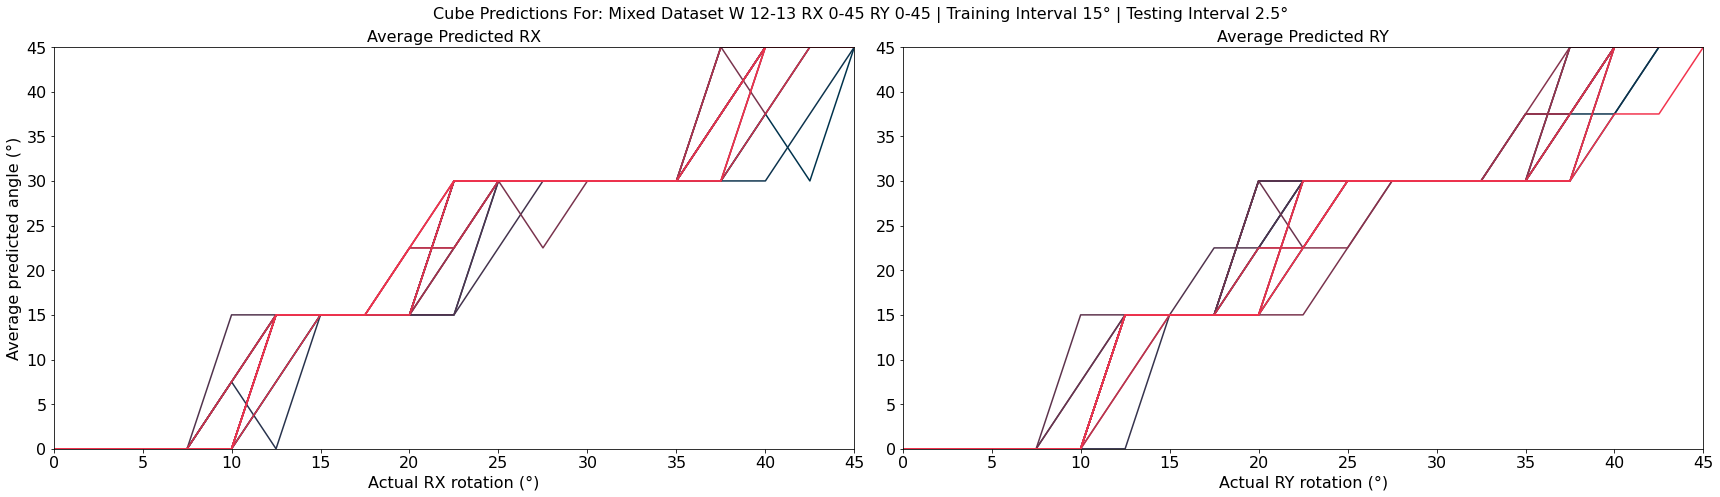

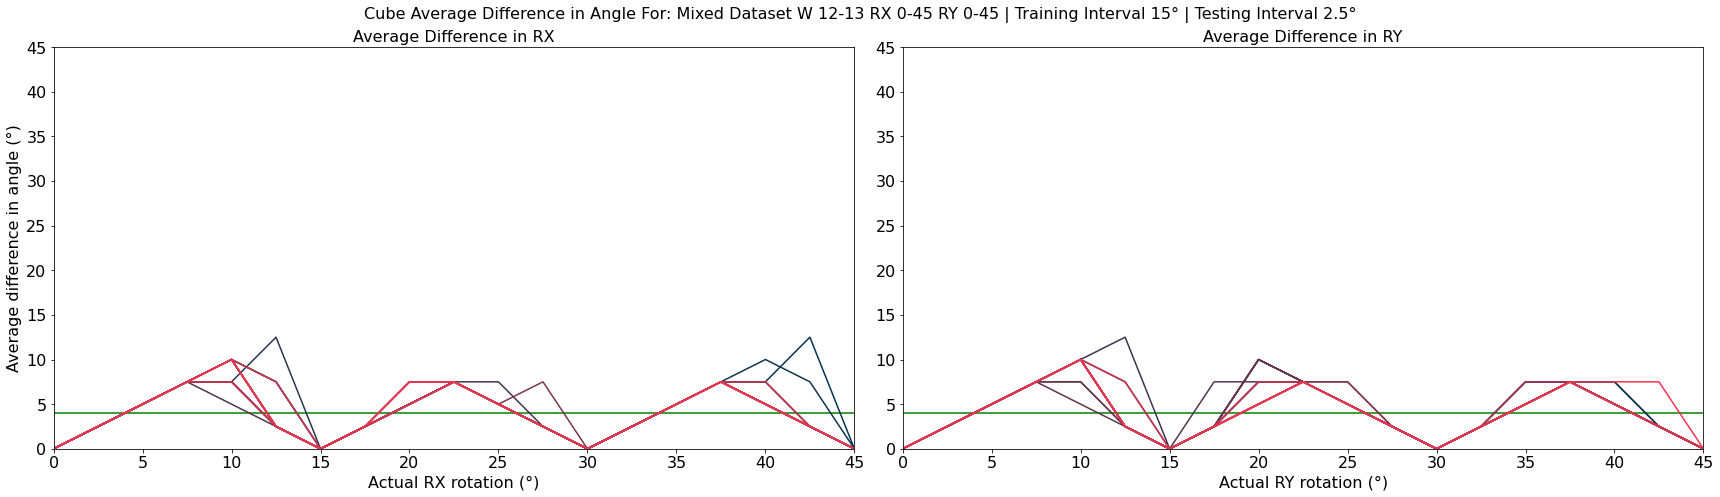

Tetrahedron:
All rotations predicted.

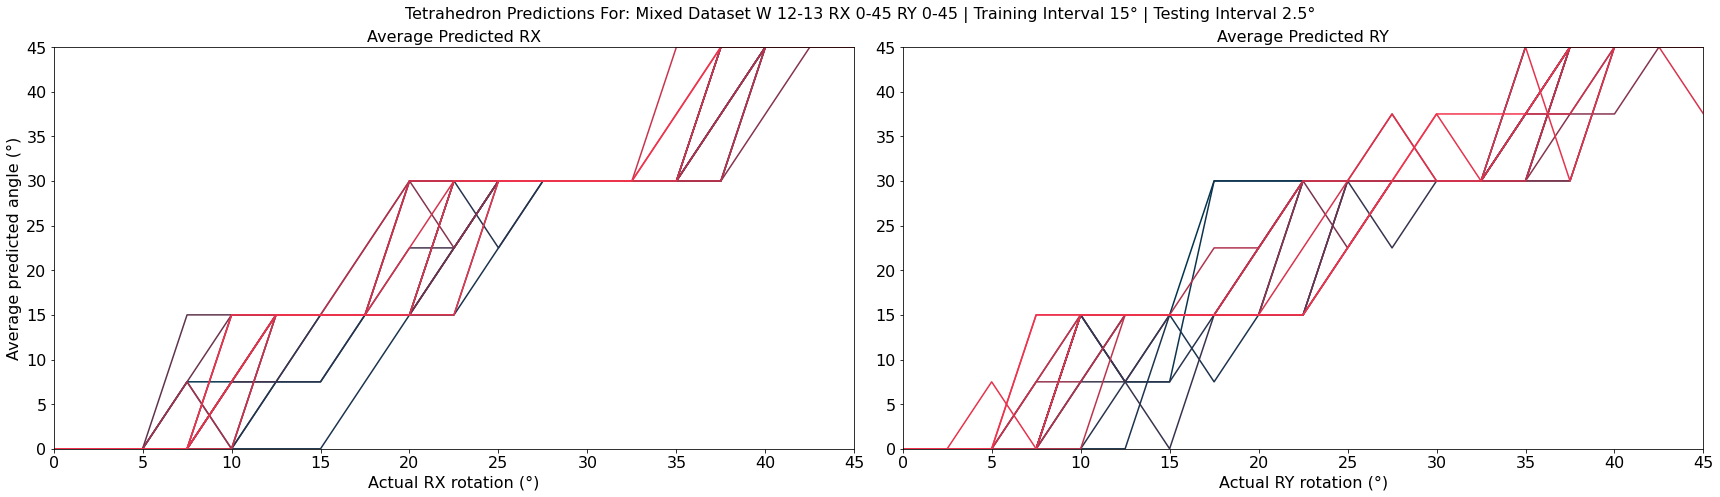

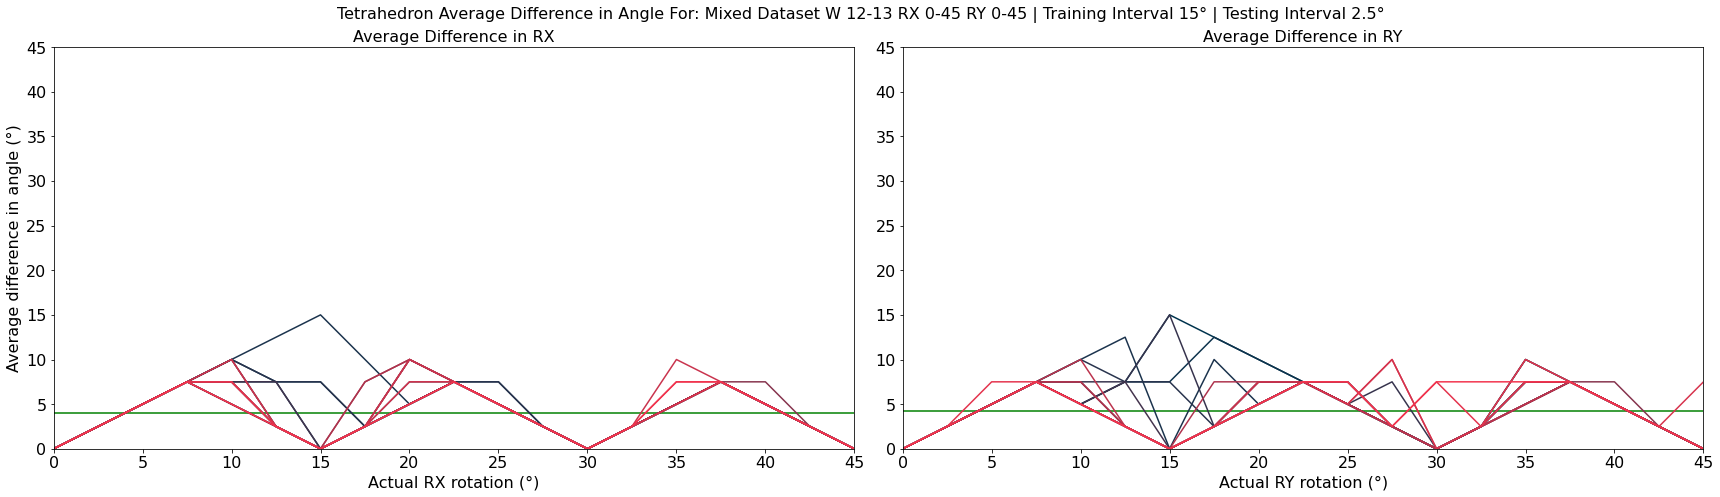

Octahedron:
All rotations predicted.

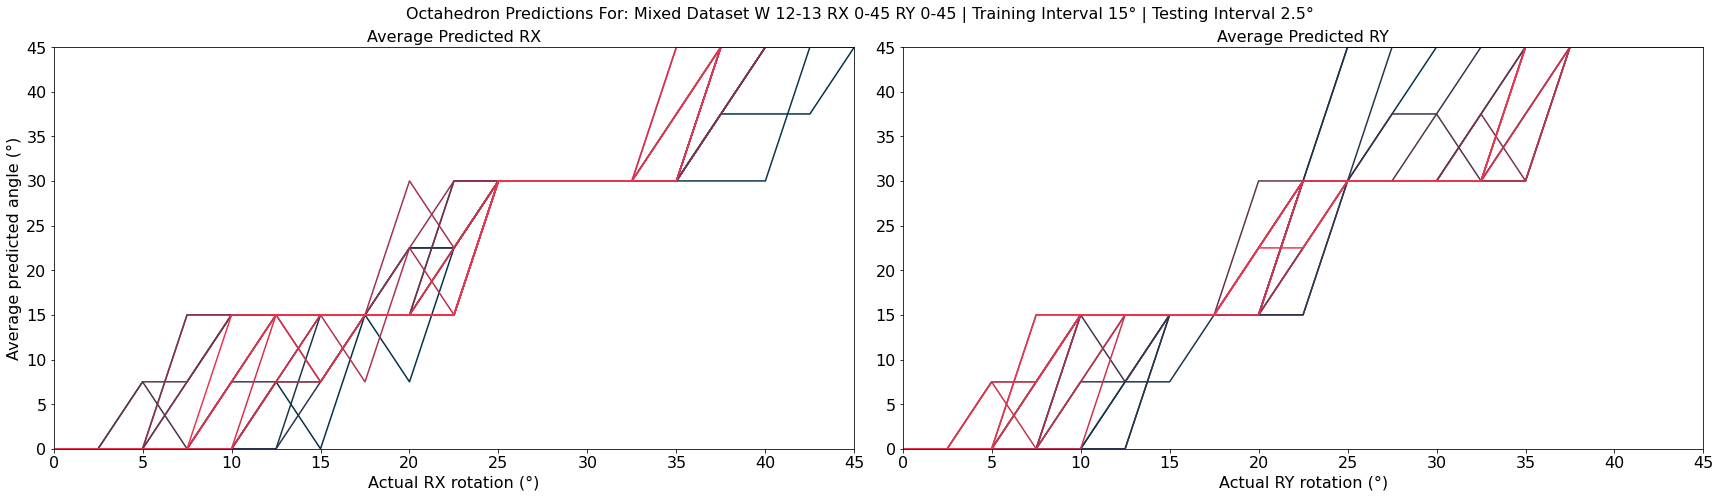

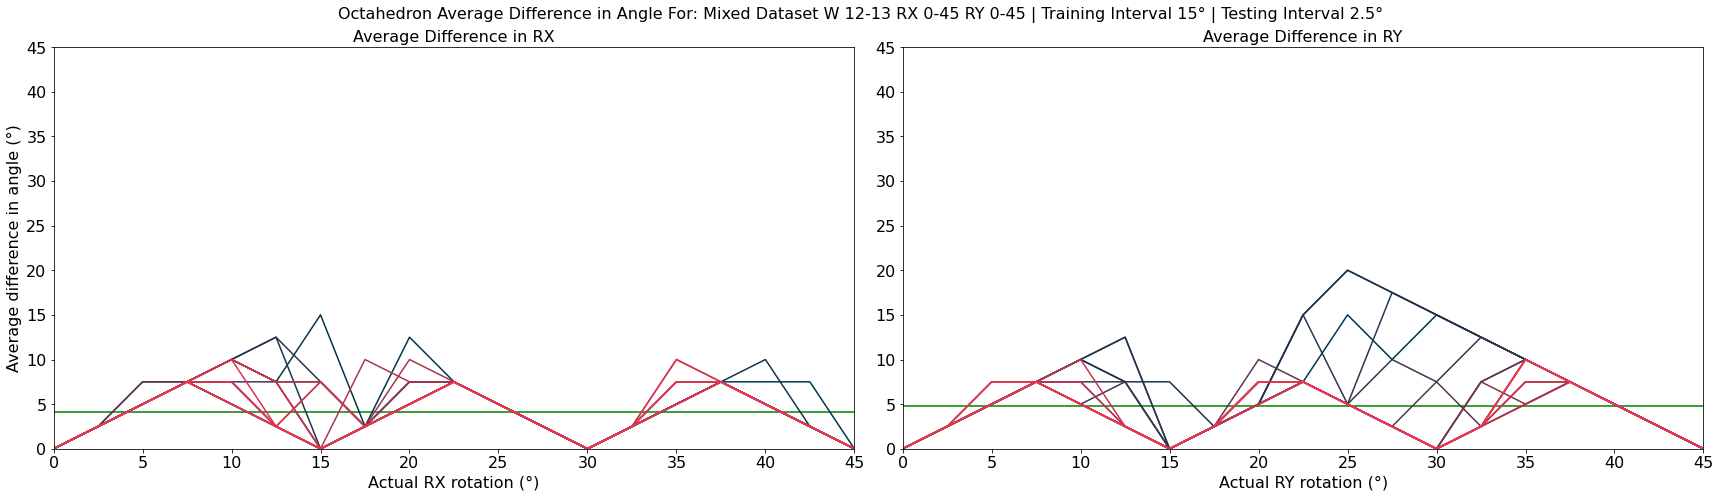

In [20]:
dr_test = 2.5
testing_path = os.path.join(direc, "Test DR%s" % dr_test)

actual_shapes = []

rotations = os.listdir(testing_path)

for rotation in rotations:
  shape = rotation.split("_")[0]
  if shape not in actual_shapes:
    actual_shapes.append(shape)

shape_groups = []

for shape in actual_shapes:
  shape_groups.append(shape_group(shape, testing_path))

In [21]:
for shape in shape_groups:
  shape.save_results()
  shape.print_results()


Results for Cube:

['DR TEST', 'DR TRAIN', 'RX AVG DIF', 'RY AVG DIF', 'CORR_SHAPES']
['2.5', '2.5', '1.326177285', '1.385041551', '0.993074792']
['5', '2.5', '1.375', '1.325', '1']
['7.5', '2.5', '1.147959184', '1.25', '1']
['15', '2.5', '1.328125', '1.171875', '1']
['2.5', '5', '2.216066482', '2.139889197', '0.984764543']
['5', '5', '1.375', '1.45', '0.975']
['7.5', '5', '2.295918367', '2.142857143', '0.969387755']
['15', '5', '1.875', '1.71875', '0.9375']
['2.5', '7.5', '2.361495845', '2.510387812', '1']
['5', '7.5', '2.25', '2.4375', '1']
['7.5', '7.5', '0.382653061', '0.612244898', '1']
['15', '7.5', '0.46875', '0.703125', '1']
['15', '15', '0', '0', '1']
['7.5', '15', '3.214285714', '3.520408163', '1']
['5', '15', '3.7', '3.8', '1.0']
['2.5', '15', '3.96814404432133', '4.037396121883656', '1.0']



Results for Tetrahedron:

['DR TEST', 'DR TRAIN', 'RX AVG DIF', 'RY AVG DIF', 'CORR_SHAPES']
['2.5', '2.5', '1.343490305', '1.322714681', '0.998614958']
['5', '2.5', '1.35', '1.375', 

In [22]:
correct_shape_predictions = []

for group in shape_groups:
  correct_shape_predictions.append(group.correct_shapes * 100)

correct_shape_predictions = np.asarray(correct_shape_predictions)
incorrect_shape_predictions = 100 - correct_shape_predictions

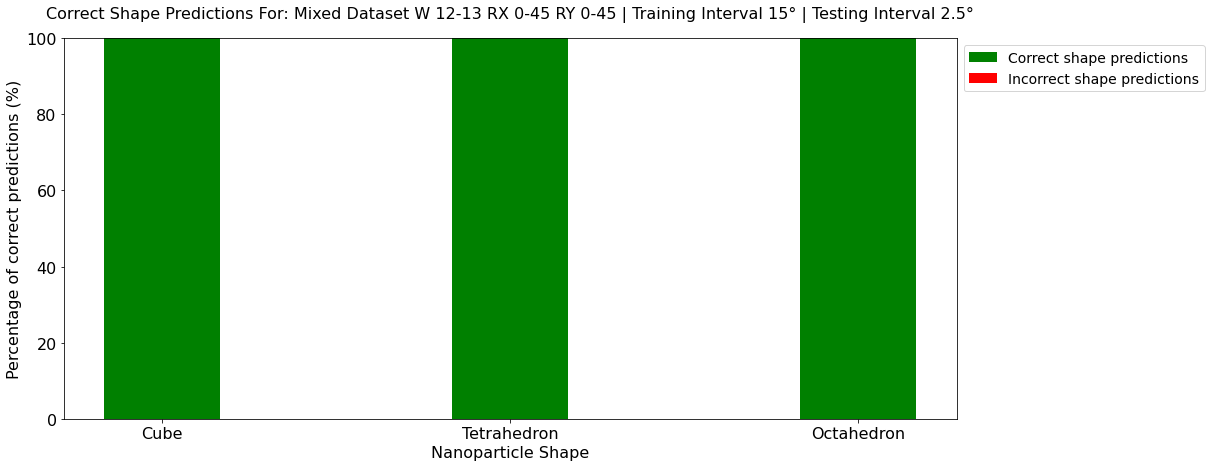

In [23]:
fig_shapes = plt.figure(figsize=(16, 7))

bar_width = 1 / len(actual_shapes)

plt.bar(actual_shapes, correct_shape_predictions, bar_width, color='g', label='Correct shape predictions')
plt.bar(actual_shapes, incorrect_shape_predictions, bar_width, color='r', label='Incorrect shape predictions', bottom=correct_shape_predictions)

plt.xlabel("Nanoparticle Shape", fontsize=16)
plt.ylim([0, 100])
plt.ylabel("Percentage of correct predictions (%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.,1), loc="upper left", fontsize=14)

plt.title("Correct Shape Predictions For: %s | Training Interval %s° | Testing Interval %s°" % (folder_name, dr_train, dr_test), fontsize=16, pad=20)
#plt.tight_layout()
plt.show()

In [24]:
results_direc = os.path.join(direc, "Results", "Classification Results")
fig_shapes_name = "Classification Shape Predictions DR_TRAIN%s DR_TEST%s.png" % (dr_train, dr_test)
fig_shapes.savefig(os.path.join(results_direc, fig_shapes_name))